In [312]:
import pygsp.graphs as graphs
import pygsp
import numpy as np
import scipy
import scipy.sparse as sp
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pandas as pd

In [130]:
import sparsify

# Using Library

In [264]:
import importlib
importlib.reload(sparsify)

<module 'sparsify' from '/Users/samuelleone/Documents/Class/math 322/Final Project/sparsify.py'>

## Generate Graph

In [265]:
A = np.zeros((50,50))
for i in range(25):
    for j in range(i,25):
        A[i,j] = 1; A[j,i] = 1;
        A[i+25,j+25] = 1; A[j+25,i+25] = 1
        
A[0,25] = 1; A[25,0] = 1

In [266]:
G = graphs.Graph(A)
G.set_coordinates()

2022-12-20 22:29:01,198:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


# Call The Sparsifier

In [267]:
sparsifier = sparsify.Sparsifier(G, epsilon = 0.2)

In [268]:
sparsifier.sparsify_by_resistances(verbose=False,method='Exact')
Resistances_Exact = sparsifier.Re
sparsifier.sparsify_by_resistances(verbose=False,method='Chebyshev')
Resistances_Chebyshev = sparsifier.Re
sparsifier.sparsify_by_resistances(verbose=False, method = 'Spielman-Srivastava')
Resistances_SS = sparsifier.Re
G_ = sparsifier.get_sparsifier()

100%|█████████████████████████████████████| 1252/1252 [00:00<00:00, 1810.36it/s]


In [351]:
print(np.corrcoef(Resistances_SS,Resistances_Exact))

[[1.         0.94885462]
 [0.94885462 1.        ]]


In [354]:
print(np.corrcoef(Resistances_SS,Resistances_Chebyshev))

[[1.         0.94041207]
 [0.94041207 1.        ]]


In [269]:
G_nx_old = nx.Graph(G.W)

## Visualize the Effective Resistances

In [270]:
len(G_nx_old.edges)

651

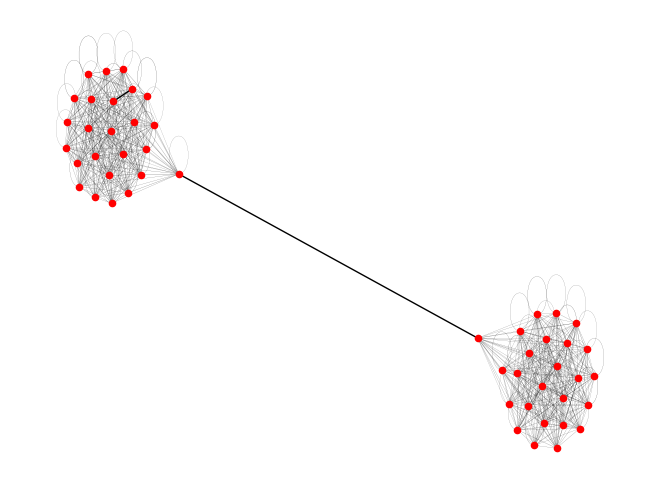

In [338]:
pos = nx.spectral_layout(G_nx_old)
nx.draw(G_nx_old,node_size=20, width = Resistances_SS, node_color = 'red',cmap='gray')
plt.savefig("Effective_Resistances.png")
plt.show()

## Changing the Number of Random Samples

In [345]:
sparsifier.q = 200
sparsifier.Sample_Edges()
G_ = sparsifier.get_sparsifier()

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1275.80it/s]


## Plotting new Graph (Edge Width Corresponds to Weight)

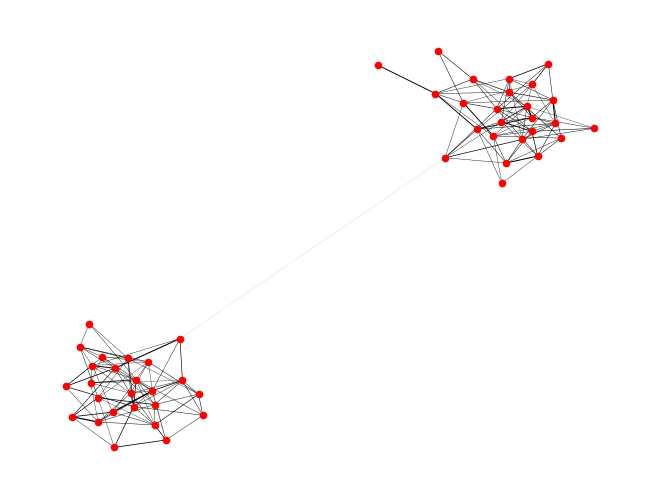

In [346]:
G_nx = nx.Graph(G_.W)
weights = [G_nx[e[0]][e[1]]['weight'] for e in list(G_nx.edges())]
pos = nx.spectral_layout(G_nx_old)
nx.draw(G_nx,node_size=20, edge_color = 'black', node_color = 'red', width = np.array(weights)/10)
plt.savefig("200_edge_approx.png")

2022-12-20 23:46:57,387:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


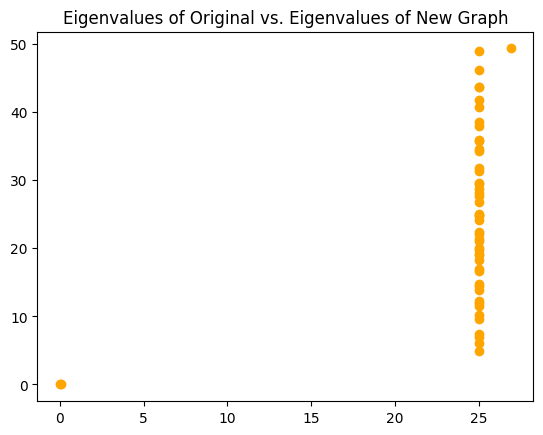

In [347]:
plt.scatter(G.e, G_.e, c = 'orange')
plt.title("Eigenvalues of Original vs. Eigenvalues of New Graph")
plt.savefig("Eigenvalue_Comparison.png")

In [348]:
q1 = []; q2 = []
L1 = G.L.todense()
L2 = G_.L.todense()
for i in range(10000):
    x = np.random.randn(G.N)
    x = x/np.linalg.norm(x)
    Q1 = np.array(x.T@L1@x)[0,0]
    Q2 = np.array(x.T@L2@x)[0,0]
    q1.append(Q1); q2.append(Q2)

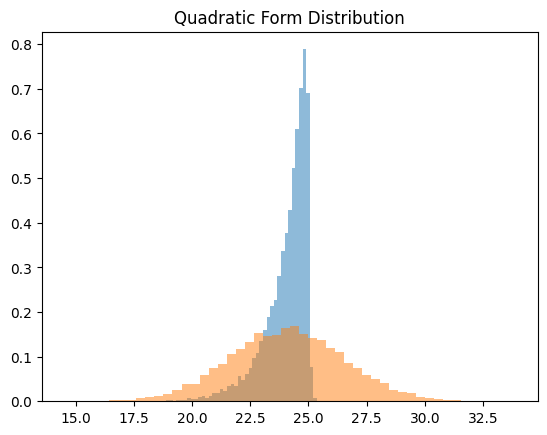

In [349]:
plt.hist(q1,bins=50,density=True,alpha=0.5)
plt.hist(q2,bins=50,density=True,alpha=0.5)
plt.title("Quadratic Form Distribution")
plt.savefig("Quadratic_difference.png")
plt.show()

In [330]:
all_results = []
for q in [150,200,300,1000,20000,100000]:
    sparsifier.q = q
    sparsifier.Sample_Edges()
    G_ = sparsifier.get_sparsifier()
    G.compute_fourier_basis()
    G_.compute_fourier_basis()
    q1 = []; q2 = []
    L1 = G.L.todense()
    L2 = G_.L.todense()

    cor =  np.corrcoef(G.e,G_.e)[0,1]
    for i in range(10000):
        x = np.random.randn(G.N)
        x = x/np.linalg.norm(x)
        Q1 = np.array(x.T@L1@x)[0,0]
        Q2 = np.array(x.T@L2@x)[0,0]
        q1.append(Q1); q2.append(Q2)
    close = max(np.abs(np.array(q1)-np.array(q2)))
    
    results = {}
    results['Correlation'] = cor
    results['Epsilon-Closness'] = close
    all_results.append(results)

100%|█████████████████████████████████| 100000/100000 [00:33<00:00, 3009.85it/s]


In [331]:
df = pd.DataFrame(all_results)
df.index = [150,200,300,1000,20000,100000]
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Correlation &  Epsilon-Closness \\
\midrule
150    &     0.355240 &         11.643839 \\
200    &     0.393768 &         10.767303 \\
300    &     0.474376 &          8.371558 \\
1000   &     0.626117 &          5.298738 \\
20000  &     0.972060 &          0.973045 \\
100000 &     0.992920 &          0.453463 \\
\bottomrule
\end{tabular}



## Ring Graph

In [872]:
N = 20
A = np.zeros((N,N))
for i in range(N):
    for k in range(1,4):
        j = (i + k) % N
        A[i,j] = 1; A[j,i] = 1
        
G = graphs.Graph(A)
sparsifier = sparsify.Sparsifier(G, epsilon = 0.2)
sparsifier.q = 30
sparsifier.sparsify_by_resistances()
G_ = sparsifier.get_sparsifier()
G_nx_old = nx.Graph(G.W)
G_nx = nx.Graph(G_.W)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 838.06it/s]


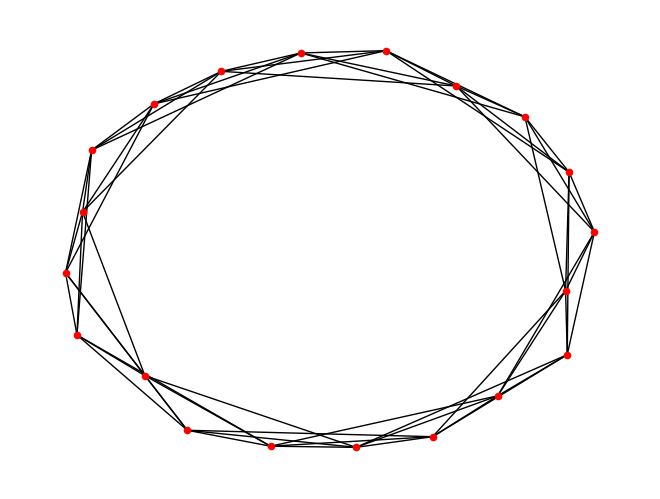

In [873]:
pos = nx.spectral_layout(G_nx_old)
nx.draw(G_nx_old,node_size=20,edge_color = 'black', node_color = 'red')

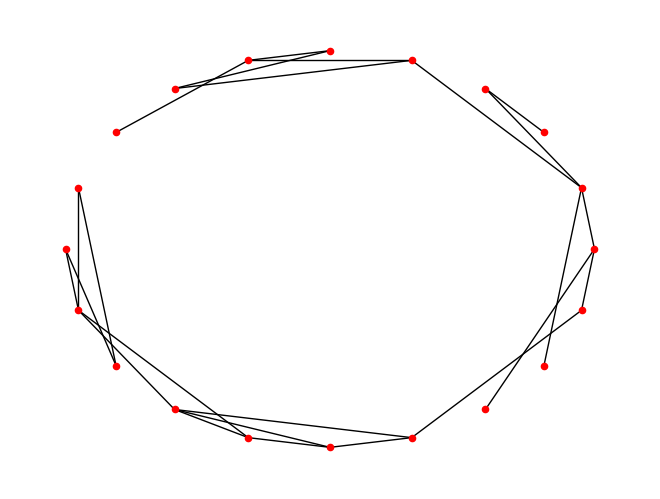

In [874]:
pos = nx.shell_layout(G_nx)
nx.draw_shell(G_nx,node_size=20,edge_color = 'black', node_color = 'red')